In [1]:
# Load packages
library(stringr)
library(rentrez)
library(dplyr)
library(tidyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Adjust PATH
wd <- getwd()
subdir <- "/bin" # should be 'scripts' if location is ./scripts/thisfile
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
getwd()

[1] "/home/dieol22p/arabinosylation-anti-CRISPR"

In [3]:
# Define functions

#' Find Pubmed entries for a topic per year
entrez_pubmed_search_count_by_year <- function(year, term){
    query <- paste(term, "AND (", year, "[PDAT])")
    entrez_search(db="pubmed", term=query, retmax=0)$count
}

#' Search number of complete genomes published per year
entrez_nucleotide_search_count_by_year <- function(year, term) {
    query <- paste(term, "AND (", year, "[PDAT])")
    entrez_search(db="nucleotide", term=query, retmax=0)$count
}

In [40]:
## Define variables

# Local files
path <- 'data/ncbi_phage-complete-genomes/'
dir.create(path, recursive = TRUE)
genomes <- list(
    entrez = 'entrez.csv',
    accession = "accession.txt"
)
for (i in names(genomes)) {genomes[[i]] <- paste0(path, genomes[[i]])}
genomes

# Queries
nucleotide_queries <- list(
    "Phage nucleotide sequences" = "phage[TITL] OR bacteriophage[TITL]",
    "Phage complete genomes" = "phage[TITL] OR bacteriophage[TITL] AND (complete genome[TITL]) "
)

Warning message in dir.create(path, recursive = TRUE):
“'data/ncbi_phage-complete-genomes' already exists”


$entrez
[1] "data/ncbi_phage-complete-genomes/entrez.csv"

$accession
[1] "data/ncbi_phage-complete-genomes/accession.txt"

In [5]:
## Search overview

# Pubmed queries
result <- list()
for (i in nucleotide_queries) {
    result[[i]] <- entrez_search(db="nucleotide", term=i, retmax=0)
}
result

# To add:
# complete sequence[TITL]
# partial genome[TITL]

$`phage[TITL] OR bacteriophage[TITL]`
Entrez search result with 102094 hits (object contains 0 IDs and no web_history object)
 Search term (as translated):  phage[TITL] OR bacteriophage[TITL] 

$`phage[TITL] OR bacteriophage[TITL] AND (complete genome[TITL]) `
Entrez search result with 26029 hits (object contains 0 IDs and no web_history object)
 Search term (as translated):  phage[TITL] OR bacteriophage[TITL] AND complete ge ... 


In [6]:
## Query data for each year

# Timeframe
data <- data.frame(year = 1950:2024)

# Nucleotide queries
for (i in names(nucleotide_queries)) {
    print(paste("Looking for", i))
    data[[i]] <- sapply(data$year, entrez_nucleotide_search_count_by_year, term=nucleotide_queries[[i]], USE.NAMES=FALSE)
}

[1] "Looking for Phage nucleotide sequences"
[1] "Looking for Phage complete genomes"


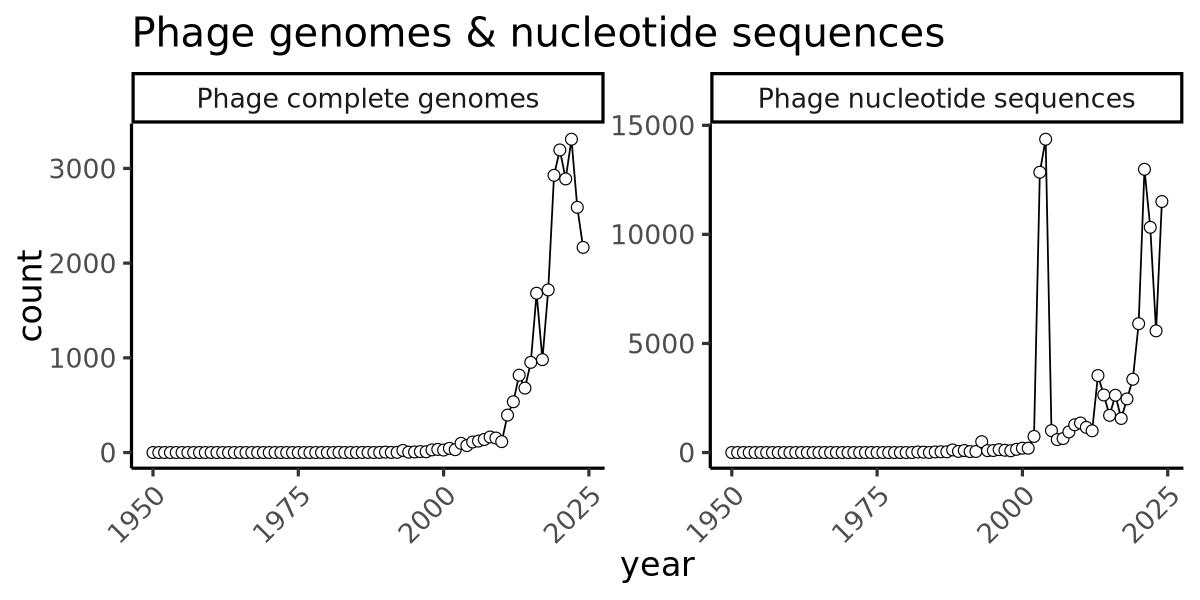

In [7]:
# Visualization
options(repr.plot.width=10, repr.plot.height=5)

## Wrangle
df <- gather(data, "search", "count", -year)

## Set factor levels


## Plot
ggplot(df, aes(year, count)) +
    geom_line() +
    geom_point(shape = 21, size = 3, fill = "white") +
    facet_wrap(~search, scales = "free_y") +
    theme_classic(20) +
    theme(
        axis.text.x = element_text(angle=45, hjust=1, vjust=1)
    ) +
    labs(title = "Phage genomes & nucleotide sequences")

In [8]:
# Mutate
df <- group_by(df, search) %>% mutate(sum=cumsum(count))

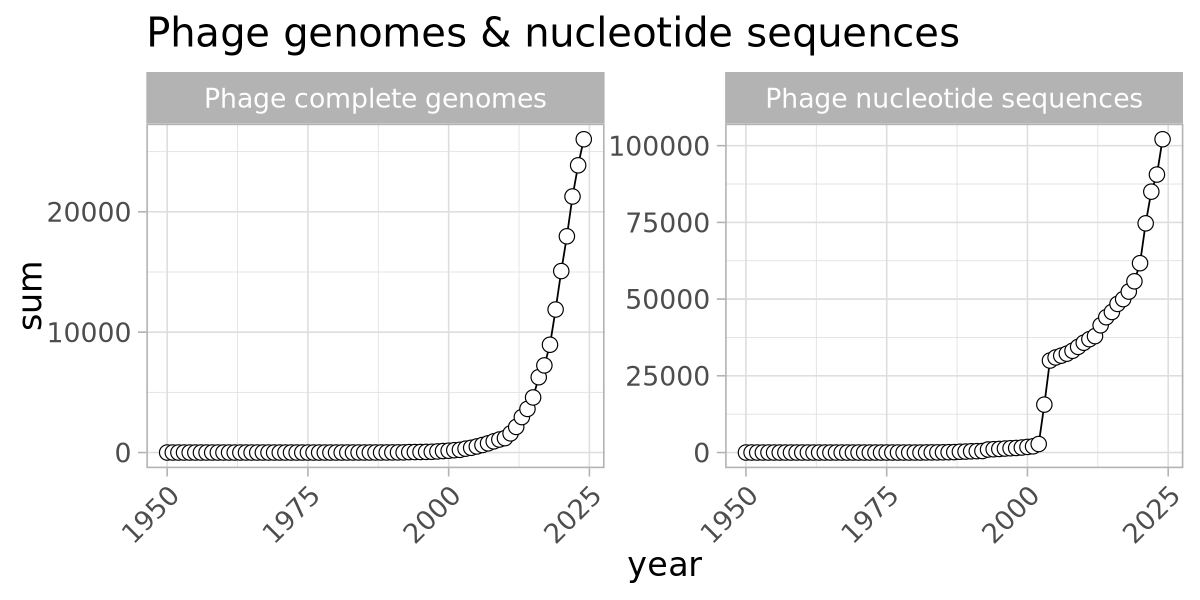

In [9]:
# Cumulative sum over years
options(repr.plot.width=10, repr.plot.height=5)

# Plot
ggplot(df, aes(year, sum)) +
    geom_line() +
    geom_point(shape = 21, size = 4, fill = "white") +
    facet_wrap(~search, scales = "free_y") +
    theme_light(20) +
    theme(
        axis.text.x = element_text(angle=45, hjust=1, vjust=1)
    ) +
    labs(title = "Phage genomes & nucleotide sequences")

Warning message:
“Removed 50 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 100 rows containing missing values or values outside the scale range (`geom_point()`).”


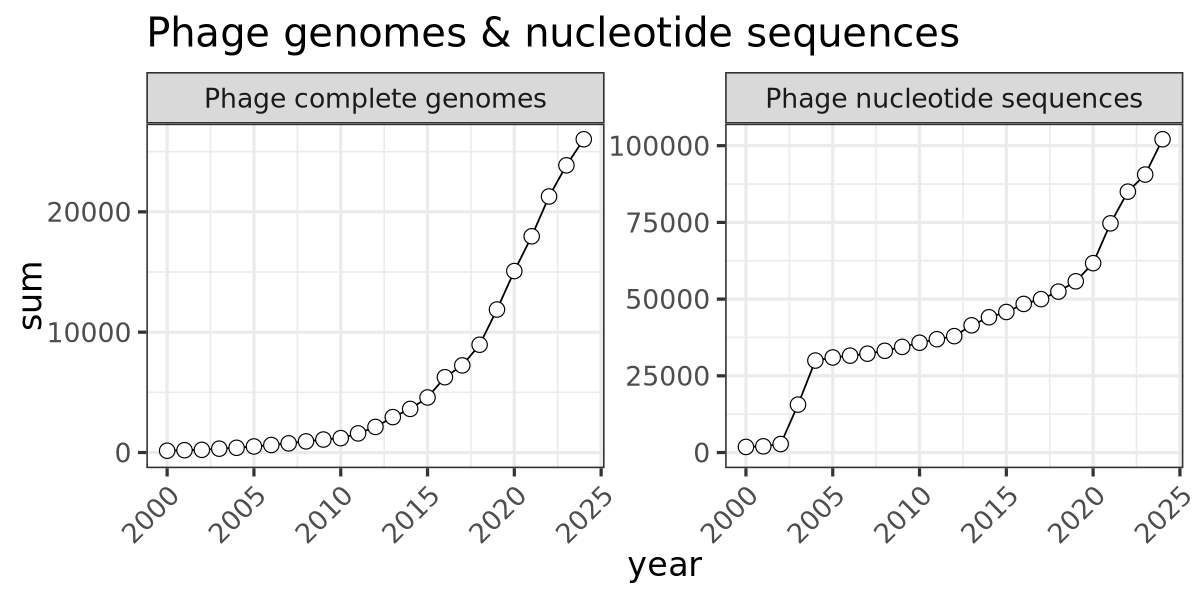

In [10]:
# Cumulative sum over years
options(repr.plot.width=10, repr.plot.height=5)

# Plot
ggplot(df, aes(year, sum)) +
    geom_line() +
    geom_point(shape = 21, size = 4, fill = "white") +
    facet_wrap(~search, scales = "free_y") +
    theme_bw(20) +
    theme(
        axis.text.x = element_text(angle=45, hjust=1, vjust=1)
    ) +
        labs(title = "Phage genomes & nucleotide sequences") +
    scale_x_continuous(limits = c(2000, NA)) # Zoom

In [17]:
result <- entrez_search(db='nuccore', term=nucleotide_queries$`Phage complete genomes`, retmax=50000)
result

Entrez search result with 26029 hits (object contains 26029 IDs and no web_history object)
 Search term (as translated):  phage[TITL] OR bacteriophage[TITL] AND complete ge ... 

In [34]:
## Convert entrez ID to nucleotide accession

query <- data.frame(
    entrez = result$ids
)

# Create groups of IDs
n_groups <- ceiling(result$count / 100)
query$group <- factor(sample(1:n_groups, nrow(query), replace=TRUE))

# Convert entrez to accession
query$accession <- NA
for (i in levels(query$group)) {
    ind <- which(query$group==i)
    x <- entrez_fetch(db='nuccore', id=query$entrez[ind], rettype='acc')
    query$accession[ind] <- head(str_split(x, "\\n")[[1]], -1)
}

rbind(head(query,3), tail(query,3))

,entrez,group,accession
,<chr>,<fct>,<chr>
1,2583821176,78,OR360731.1
2,2780153588,32,PP934564.1
3,2780153505,1,PP934563.1
26027,44995224,94,AY526909.1
26028,44995150,14,AY526908.1
26029,7406588,250,AJ270057.1


In [44]:
# Write accession numbers to file
write.table(query, genomes$entrez, sep = ',', quote = FALSE, row.names = FALSE)
writeLines(query$accession, genomes$accession)

In [45]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 9.2 (Blue Onyx)

Matrix products: default
BLAS/LAPACK: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Pacific/Auckland
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.5.1 tidyr_1.3.1   dplyr_1.1.4   rentrez_1.2.3 stringr_1.5.1

loaded via a namespace (and not attached):
 [1] gtable_0.3.6      jsonlite_1.8.9    compiler_4.3.3    crayon_1.5.3